In [2]:
import pandas
import numpy as np
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [3]:
data = pandas.read_csv('https://drive.google.com/uc?export=download&id=10cwdWd4axXdQX-53FBecxRo1bcXcQVP4')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [10]:
from datetime import datetime
data['join_date'] = pandas.to_datetime(data['join_date'])
data['quit_date'] = pandas.to_datetime(data['quit_date'])
data.describe(include='all')

C:\Users\syy19\AppData\Local\Temp/ipykernel_13132/1314400038.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
count,24702.000000,24702.000000,24702,24702.000000,24702.000000,24702,13510
unique,NaN,NaN,6,NaN,NaN,995,664
top,NaN,NaN,customer_service,NaN,NaN,2012-01-03 00:00:00,2015-05-08 00:00:00
freq,NaN,NaN,9180,NaN,NaN,105,111
first,NaN,NaN,NaN,NaN,NaN,2011-01-24 00:00:00,2011-10-13 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2015-12-10 00:00:00,2015-12-09 00:00:00
mean,501604.403530,3.426969,NaN,14.127803,138183.345478,NaN,NaN
std,288909.026101,2.700011,NaN,8.089520,76058.184573,NaN,NaN
min,36.000000,1.000000,NaN,1.000000,17000.000000,NaN,NaN
25%,250133.750000,1.000000,NaN,7.000000,79000.000000,NaN,NaN


In [14]:
# create list of unique dates
unique_dates = pandas.date_range(start='2011/01/24', end='2015/12/13')
# create list of unique companies
unique_companies = data['company_id'].unique()

In [15]:
# cross join to get all combinations of dates and companies
data_headcount = pandas.MultiIndex.from_product([unique_dates, unique_companies], names=['date','company_id'])
data_headcount = pandas.DataFrame(index = data_headcount).reset_index()

In [20]:
data_join = data.groupby(['join_date', 'company_id']).size().reset_index(name='join_count')
data_join.columns.values[0] = 'date'
data_quit = data.groupby(['quit_date', 'company_id']).size().reset_index(name='quit_count')
data_quit.columns.values[0] = 'date'

In [22]:
data_headcount = pandas.merge(data_headcount, data_join, on=['date', 'company_id'], how='left')
data_headcount = pandas.merge(data_headcount, data_quit, on=['date', 'company_id'], how='left')
data_headcount.fillna(0, inplace=True)

In [23]:
# cumulative sum by company
data_headcount['cumsum_join'] = data_headcount.groupby(['company_id'])['join_count'].apply(lambda x:x.cumsum())
data_headcount['cumsum_quit'] = data_headcount.groupby(['company_id'])['quit_count'].apply(lambda x:x.cumsum())

In [25]:
data_headcount['count'] = data_headcount['cumsum_join'] - data_headcount['cumsum_quit']
data_headcount_table = data_headcount[['date', 'company_id', 'count']]
data_headcount_table.query('company_id==1').head(15)

,date,company_id,count
4,2011-01-24,1,25.0
16,2011-01-25,1,27.0
28,2011-01-26,1,29.0
40,2011-01-27,1,29.0
52,2011-01-28,1,29.0
64,2011-01-29,1,29.0
76,2011-01-30,1,29.0
88,2011-01-31,1,59.0
100,2011-02-01,1,66.0
112,2011-02-02,1,67.0


In [28]:
loop_cumsum = []
loop_date = []
loop_company = []
for i in unique_dates:
    for j in unique_companies:
        # count joins
        tmp_join = data[(data['join_date'] <= i) & (data['company_id'] == j)].shape[0]
        # count quits
        tmp_quit = data[(data['quit_date'] <= i) & (data['company_id'] == j)].shape[0]
        loop_cumsum.append(tmp_join - tmp_quit)
        loop_date.append(i)
        loop_company.append(j)
data_headcount_table_loop = pandas.DataFrame({'date':loop_date, 'company_id':loop_company, 'count':loop_cumsum})
data_headcount_table_loop.query('company_id==1').head(15)

,date,company_id,count
4,2011-01-24,1,25
16,2011-01-25,1,27
28,2011-01-26,1,29
40,2011-01-27,1,29
52,2011-01-28,1,29
64,2011-01-29,1,29
76,2011-01-30,1,29
88,2011-01-31,1,59
100,2011-02-01,1,66
112,2011-02-02,1,67


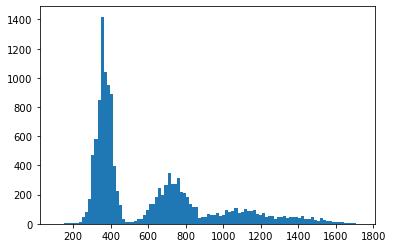

In [30]:
# feature engineering
import matplotlib.pyplot as plt
data['employment_length'] = (data['quit_date'] - data['join_date']).astype('timedelta64[D]')
plt.hist(data['employment_length'].dropna(), bins=100)
plt.show()

In [31]:
# create binary class for users quit within 13 months or not
from datetime import timedelta
data = data[data['join_date'] < datetime.strptime('2015/12/13','%Y/%m/%d') - timedelta(days=(365+31))]
data['early_quitter'] = np.where((data['employment_length'] > 396) | (np.isnan(data['employment_length'])),0,1)

In [34]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
data_dummy = pandas.get_dummies(data[['company_id', 'dept', 'seniority', 'salary', 'early_quitter']], drop_first=True)

In [35]:
# use decision tree as a descriptive stat tool
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=30, class_weight='balanced', min_impurity_decrease=0.001)
tree.fit(data_dummy.drop('early_quitter', axis=1), data['early_quitter'])

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_impurity_decrease=0.001, min_samples_leaf=30)

In [36]:
export_graphviz(tree, out_file='tree_employee.dot', 
                feature_names=data_dummy.drop('early_quitter', axis=1).columns, 
                proportion=True, rotate=True)
with open('tree_employee.dot') as f:
    dot_graph = f.read()
s = Source.from_file('tree_employee.dot')
s.view()

'tree_employee.dot.pdf'

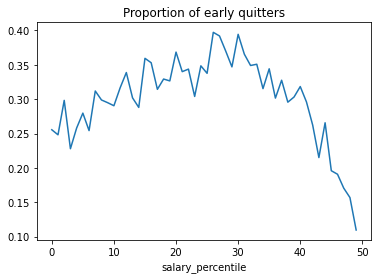

In [38]:
# plotting proportion of early quitters by salary percentile
data['salary_percentile'] = pandas.qcut(data['salary'], q=50, labels=False)
data.groupby('salary_percentile')['early_quitter'].mean().plot(title='Proportion of early quitters')
plt.show()